# LSTM with Initial Data using 5 features

In [1]:
#Links for Datasets to be downloaded
#Link of Dataset online : https://www.kaggle.com/dpamgautam/stock-price-data-for-forecasting-problems
#link for next 60 day Actual Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days

In [2]:
import numpy as np
# fetching dataset
# making dataframe
import pandas as pd
# for plotting graphs
import matplotlib.pyplot as plt
# we have used this to convert date in string in .csv file to datetime format(YY-MM-DD) for visualization
import datetime as dt
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# (1) EarlyStopping - Stop training when a monitored metric(all features together) has stopped improving
# (2) ReduceLROnPlateau - Reduce learning rate when a metric(all features together) has stopped improving.
# (3) ModelCheckpoint - is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) 
#                   at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# (4) TensorBoard - saves train and validation files generated during the model training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# StandardScaler-it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1
from sklearn.preprocessing import StandardScaler

# will make your plot outputs appear and be stored within the notebook.
%matplotlib inline

In [3]:
#Link of Dataset online : https://www.kaggle.com/dpamgautam/stock-price-data-for-forecasting-problems
df = pd.read_csv ("stock_price_dada.csv") 
df=  df.iloc[::-1] 
df = df.set_index('Date') 
df.index = pd.to_datetime(df.index) 
df.to_csv('stock_price_dada_inverse.csv') 

In [4]:
data = pd.read_csv('stock_price_dada_inverse.csv')
data.drop('Total Trade Quantity', axis=1, inplace=True)
data.drop('Turnover (Lacs)', axis=1, inplace=True)
data

,Date,Open,High,Low,Last,Close
0,2013-10-08,157.00,157.80,155.20,155.80,155.80
1,2013-10-09,155.70,158.20,154.15,155.30,155.55
2,2013-10-10,156.00,160.80,155.85,160.30,160.15
3,2013-10-11,161.15,163.45,159.00,159.80,160.05
4,2013-10-14,160.85,161.45,157.70,159.30,159.45
...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20


In [5]:
columns = list(data)[1:6]
date = list(data['Date'])
date = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date]


print('Number of features selected: {}'.format(columns))

Number of features selected: ['Open', 'High', 'Low', 'Last', 'Close']


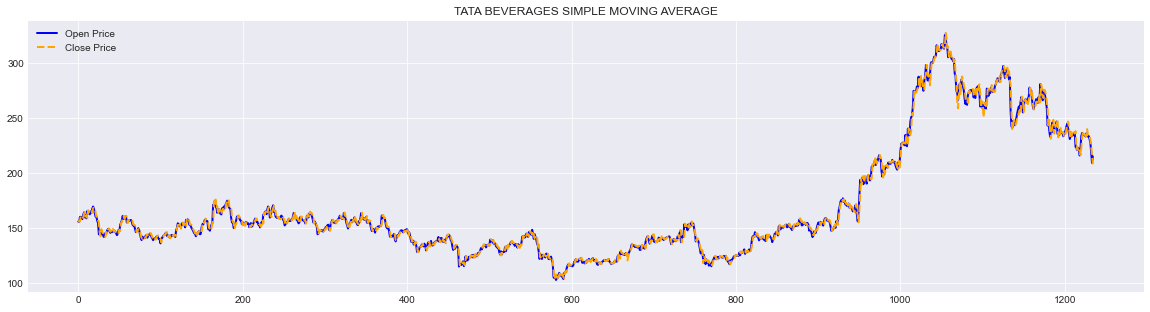

In [6]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (20, 5)
data['Close'].plot(label = 'Open Price', color = 'blue', linewidth = 2.0)
data['Open'].plot(label = 'Close Price', linestyle = '--', linewidth = 2.0, color = 'orange')
plt.legend(loc = 'upper left')
plt.title('TATA BEVERAGES SIMPLE MOVING AVERAGE')
plt.show()

In [7]:
# PREPROCESSING -converting the float values in columns to string
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

# converting the data back to from string to float
data = data.astype(float)

# Using multiple features (predictors)
# train_values will be used for normalization
# train_values is a 2D-array having only each row in each sub-array
# Rows: 1235 
# Columns: 5(Open, High, Low, Last, Close)
train_values = data.values

print('Shape of training set == {}.'.format(train_values.shape))
train_values

Shape of training set == (1235, 5).


array([[157.  , 157.8 , 155.2 , 155.8 , 155.8 ],
       [155.7 , 158.2 , 154.15, 155.3 , 155.55],
       [156.  , 160.8 , 155.85, 160.3 , 160.15],
       ...,
       [223.5 , 227.8 , 216.15, 217.25, 218.2 ],
       [217.  , 218.6 , 205.9 , 210.25, 209.2 ],
       [208.  , 222.25, 206.85, 216.  , 215.15]])

In [8]:
# The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
# StandardScaler performs the task of Standardization. 
# Usually a dataset contains variables that are different in scale. 
# For e.g. an Employee dataset will contain AGE column with values on scale 20-70 
# and SALARY column with values on scale 10000-80000.
# As these two columns are different in scale, they are Standardized to have common scale while building machine learning model.
r = StandardScaler()
# fit_transform() is used on the training data so that we can scale the training data
train_scaling = r.fit_transform(train_values)

scaling = StandardScaler()
scaling.fit_transform(train_values[:, 0:1])

array([[-0.23223106],
       [-0.25748443],
       [-0.25165673],
       ...,
       [ 1.05957561],
       [ 0.93330879],
       [ 0.75847781]])

In [9]:
# Creating a data structure with 90 timestamps and 1 output
# Creating lists(X_trian, y_train) for storing the data for training.
# training INPUT
X_train = []
# storing data of Close columns
# values we want to predict
# training OUTPUT
y_train = []

# So the LSTM will be using 90 past days data to make a prediction.
# And similarly we will be do the predictions for next 60 days.
n_future = 60   # Number of days we want to make the prediction in the future
n_past = 90     # Number of past days we want to use to predict the future


# len(train_scaling) = 1235
for i in range(n_past, len(train_scaling) - n_future +1):
    X_train.append(train_scaling[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(train_scaling[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# (1067, 90, 5) (rows, columns, features(High, Low, Last, Close))
print('X_train shape == {}.'.format(X_train.shape))
# (1067, 1) (rows, feature(Open))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1086, 90, 4).
y_train shape == (1086, 1).


In [10]:
# LSTM MODEL CREATION
# initializing the neural network based on LSTM 
model = Sequential()
# layer 1 with 64 Nodes 
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))
# layer 2 with 10 Nodes
model.add(LSTM(units=10, return_sequences=False))
# Layer 3 is a Dropout Layer to avoid Overfitting
model.add(Dropout(0.25))
# Layer 4 is always the Dense layer 
# units = 1 since we are prdicting only one value i.e Open price
model.add(Dense(units=1, activation='linear'))
# useing adam optimizer
model.compile(optimizer = "adam", loss='mean_squared_error')

In [11]:
%%time
# %%time :- prints the wall time(total time to execute a program in a computer) for the entire cell
# MODEL TRAINING
# EarlyStopping - Stop training when a monitored metric has stopped improving.
# monitor - quantity to be monitored.
# min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
# patience - number of epochs with no improvement after which training will be stopped.
# ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
# factor - factor by which the learning rate will be reduced.
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 15s 506ms/step - loss: 0.5894 - val_loss: 4.0234

Epoch 00001: val_loss improved from inf to 4.02335, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 0s 115ms/step - loss: 0.2197 - val_loss: 2.8475

Epoch 00002: val_loss improved from 4.02335 to 2.84755, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 0s 113ms/step - loss: 0.1882 - val_loss: 2.3467

Epoch 00003: val_loss improved from 2.84755 to 2.34666, saving model to weights.h5
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.1992 - val_loss: 2.2002

Epoch 00004: val_loss improved from 2.34666 to 2.20019, saving model to weights.h5
Epoch 5/30
4/4 [==============================] - 0s 112ms/step - loss: 0.1679 - val_loss: 2.1767

Epoch 00005: val_loss improved from 2.20019 to 2.17672, saving model to weights.h5
Epoch 6/30
4/4 [==============================] - 0s 111ms/step - loss: 0.1693 - val_loss: 2.

In [12]:
# storing the next 60 days date for predixtion of future opening prices
future_list = pd.date_range(date[-1], periods=n_future, freq='1d').tolist()

future_list_ = []
for this_timestamp in future_list:
    future_list_.append(this_timestamp.date())

In [13]:
# Perform Prediction
train_predict = model.predict(X_train[n_past:])
future_predict = model.predict(X_train[-n_future:])

In [14]:
# x i.e date in string
# returns datetime format of x
def timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [15]:
# inverse the predictions to original values
predicted_train = scaling.inverse_transform(train_predict)
predicted_future = scaling.inverse_transform(future_predict)

In [16]:
predicted_train.shape,predicted_future.shape

((996, 1), (60, 1))

In [17]:
# making a dataframe for the future and predicted trained vales
FUTURE_PRED = pd.DataFrame(predicted_future, columns=['Open']).set_index(pd.Series(future_list))
TRAIN_PRED = pd.DataFrame(predicted_train, columns=['Open']).set_index(pd.Series(date[2 * n_past + n_future -1:]))

In [18]:
# 
TRAIN_PRED.index = TRAIN_PRED.index.to_series().apply(timestamp)
TRAIN_PRED.tail()

,Open
2018-10-01,293.136749
2018-10-03,293.328735
2018-10-04,293.490906
2018-10-05,293.428619
2018-10-08,293.361115


In [19]:
FUTURE_PRED.index = FUTURE_PRED.index.to_series().apply(timestamp)
FUTURE_PRED.tail()

,Open
2018-12-02,293.136749
2018-12-03,293.328766
2018-12-04,293.490906
2018-12-05,293.428619
2018-12-06,293.361115


In [20]:
df = pd.read_csv ("stock_price_dada_inverse.csv")
df = df.set_index('Date')
df = df[df.index >= '2014-09-24']
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2014-09-24,165.20,166.75,161.80,165.00,164.75,2219635.0,3644.90
2014-09-25,165.40,165.65,159.10,161.20,160.30,2973253.0,4790.09
2014-09-26,159.00,161.95,154.45,160.10,159.65,2924724.0,4637.96
2014-09-29,160.00,161.90,158.30,159.00,159.00,2096263.0,3353.22
2014-09-30,159.10,162.40,157.60,159.40,159.35,1917772.0,3068.51
...,...,...,...,...,...,...,...
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [21]:
#link for next 60 day Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days
dk = pd.read_csv('Tata Global Beverages Ltd Next 60 Days__.csv')
dk = dk.set_index('Date')
dm = pd.DataFrame(dk, columns=['Open']).set_index(pd.Series(future_list))
dm.tail()

,Open
2018-12-02,223.00
2018-12-03,219.55
2018-12-04,218.50
2018-12-05,214.20
2018-12-06,212.00


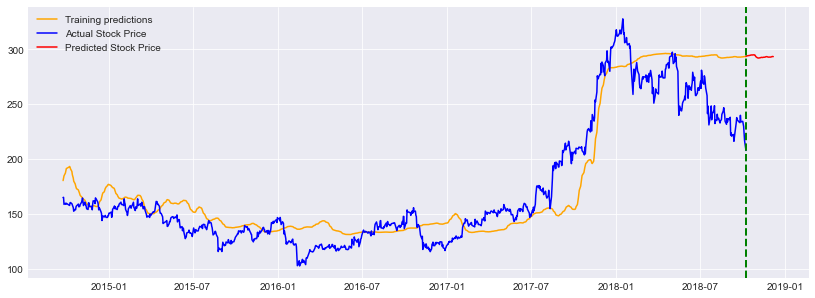

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-09-24'
plt.plot(TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:].index,TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')
plt.plot(FUTURE_PRED.index, FUTURE_PRED['Open'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(FUTURE_PRED.index), color='green', linewidth=2, linestyle='--')
plt.legend()

In [23]:
Performance =  TRAIN_PRED['Open']-df['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/df['Open'])
net_Percentage_Original = Percentage.mean()
net_Percentage_Original

89.20156281115356

In [24]:
Performance =  FUTURE_PRED['Open']-dm['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/dm['Open'])
net_Percentage_Original_future = Percentage.mean()
net_Percentage_Original_future

65.0463655086839

# LSTM with 6 Features which Includes Simple Moving Average

In [25]:
data = pd.read_csv('stock_price_dada_inverse.csv')
data.drop('Total Trade Quantity', axis=1, inplace=True)
data.drop('Turnover (Lacs)', axis=1, inplace=True)
data

,Date,Open,High,Low,Last,Close
0,2013-10-08,157.00,157.80,155.20,155.80,155.80
1,2013-10-09,155.70,158.20,154.15,155.30,155.55
2,2013-10-10,156.00,160.80,155.85,160.30,160.15
3,2013-10-11,161.15,163.45,159.00,159.80,160.05
4,2013-10-14,160.85,161.45,157.70,159.30,159.45
...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20


In [26]:
def SimpleMovingAverage(datas, window):
    sma = datas.rolling(window = window).mean()
    return sma

data['sma_20'] = SimpleMovingAverage(data['Open'], 20)
data.fillna(0)

,Date,Open,High,Low,Last,Close,sma_20
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,0.000
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,0.000
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,0.000
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,0.000
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,0.000
...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,230.750
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,230.400
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,229.775
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,228.715


In [27]:
columns = list(data)[1:7]
date = list(data['Date'])
date = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date]


print('Number of features selected: {}'.format(columns))

Number of features selected: ['Open', 'High', 'Low', 'Last', 'Close', 'sma_20']


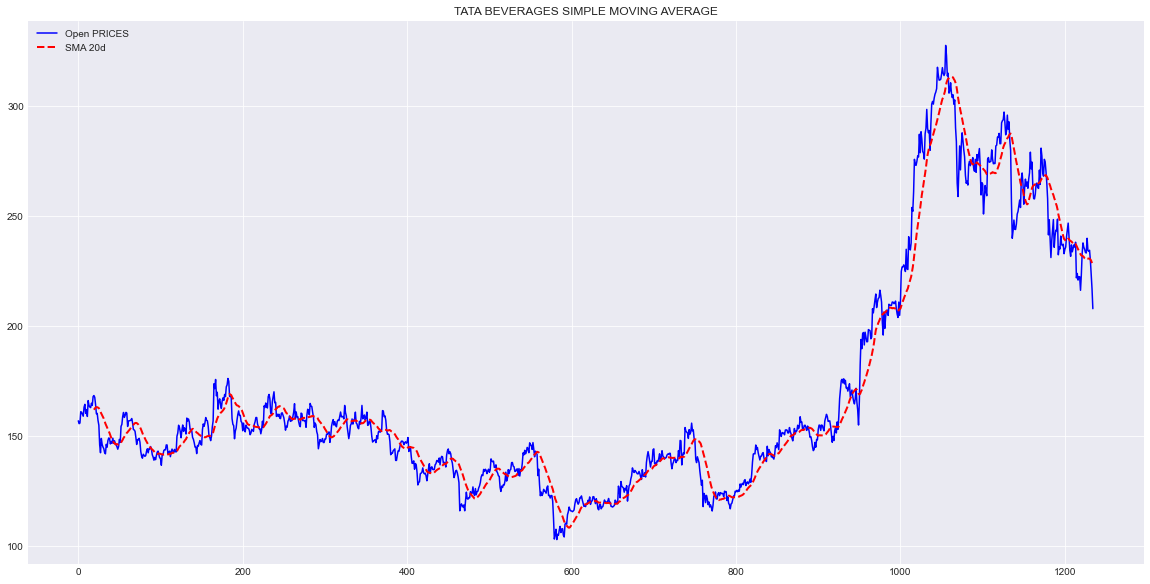

In [28]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (20, 10)
data['Open'].plot(label = 'Open PRICES', color = 'blue')
data['sma_20'].plot(label = 'SMA 20d', linestyle = '--', linewidth = 2, color = 'red')
plt.legend(loc = 'upper left')
plt.title('TATA BEVERAGES SIMPLE MOVING AVERAGE')
plt.show()

In [29]:
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

data = data.astype(float)

# Using multiple features (predictors)
train_values = data.values

print('Shape of training set == {}.'.format(train_values.shape))
train_values

Shape of training set == (1235, 6).


array([[157.   , 157.8  , 155.2  , 155.8  , 155.8  ,     nan],
       [155.7  , 158.2  , 154.15 , 155.3  , 155.55 ,     nan],
       [156.   , 160.8  , 155.85 , 160.3  , 160.15 ,     nan],
       ...,
       [223.5  , 227.8  , 216.15 , 217.25 , 218.2  , 229.775],
       [217.   , 218.6  , 205.9  , 210.25 , 209.2  , 228.715],
       [208.   , 222.25 , 206.85 , 216.   , 215.15 , 228.015]])

In [30]:
r = StandardScaler()
train_scaling = r.fit_transform(train_values)

scaling = StandardScaler()
scaling.fit_transform(train_values[:, 0:1])

array([[-0.23223106],
       [-0.25748443],
       [-0.25165673],
       ...,
       [ 1.05957561],
       [ 0.93330879],
       [ 0.75847781]])

In [31]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(train_scaling) - n_future +1):
    X_train.append(train_scaling[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(train_scaling[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1086, 90, 5).
y_train shape == (1086, 1).


In [32]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = "adam", loss='mean_squared_error')

In [33]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 4s 513ms/step - loss: 0.5967 - val_loss: 4.0227

Epoch 00001: val_loss improved from inf to 4.02268, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 0s 110ms/step - loss: 0.1742 - val_loss: 3.2493

Epoch 00002: val_loss improved from 4.02268 to 3.24931, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 0s 111ms/step - loss: 0.2132 - val_loss: 2.9023

Epoch 00003: val_loss improved from 3.24931 to 2.90232, saving model to weights.h5
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.1944 - val_loss: 2.7499

Epoch 00004: val_loss improved from 2.90232 to 2.74985, saving model to weights.h5
Epoch 5/30
4/4 [==============================] - 0s 114ms/step - loss: 0.1819 - val_loss: 2.6694

Epoch 00005: val_loss improved from 2.74985 to 2.66942, saving model to weights.h5
Epoch 6/30
4/4 [==============================] - 0s 113ms/step - loss: 0.1725 - val_loss: 2.5

In [34]:
future_list = pd.date_range(date[-1], periods=n_future, freq='1d').tolist()

future_list_ = []
for this_timestamp in future_list:
    future_list_.append(this_timestamp.date())

In [35]:
train_predict = model.predict(X_train[n_past:])
future_predict = model.predict(X_train[-n_future:])

In [36]:
def timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [37]:
predicted_train = scaling.inverse_transform(train_predict)
predicted_future = scaling.inverse_transform(future_predict)

In [38]:
predicted_train.shape,predicted_future.shape

((996, 1), (60, 1))

In [39]:
FUTURE_PRED = pd.DataFrame(predicted_future, columns=['Open']).set_index(pd.Series(future_list))
TRAIN_PRED = pd.DataFrame(predicted_train, columns=['Open']).set_index(pd.Series(date[2 * n_past + n_future -1:]))

In [40]:
TRAIN_PRED.index = TRAIN_PRED.index.to_series().apply(timestamp)
TRAIN_PRED.tail()

,Open
2018-10-01,253.762070
2018-10-03,253.570129
2018-10-04,253.452850
2018-10-05,253.411789
2018-10-08,253.379120


In [41]:
FUTURE_PRED.index = FUTURE_PRED.index.to_series().apply(timestamp)
FUTURE_PRED.tail()

,Open
2018-12-02,253.762070
2018-12-03,253.570129
2018-12-04,253.452850
2018-12-05,253.411789
2018-12-06,253.379120


In [42]:
df = pd.read_csv ("stock_price_dada_inverse.csv")
df = df.set_index('Date')
df = df[df.index >= '2014-09-24']
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2014-09-24,165.20,166.75,161.80,165.00,164.75,2219635.0,3644.90
2014-09-25,165.40,165.65,159.10,161.20,160.30,2973253.0,4790.09
2014-09-26,159.00,161.95,154.45,160.10,159.65,2924724.0,4637.96
2014-09-29,160.00,161.90,158.30,159.00,159.00,2096263.0,3353.22
2014-09-30,159.10,162.40,157.60,159.40,159.35,1917772.0,3068.51
...,...,...,...,...,...,...,...
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [43]:
#link for next 60 day Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days
dk = pd.read_csv('Tata Global Beverages Ltd Next 60 Days__.csv')
dk = dk.set_index('Date')
dm = pd.DataFrame(dk, columns=['Open']).set_index(pd.Series(future_list))
dm.tail()

,Open
2018-12-02,223.00
2018-12-03,219.55
2018-12-04,218.50
2018-12-05,214.20
2018-12-06,212.00


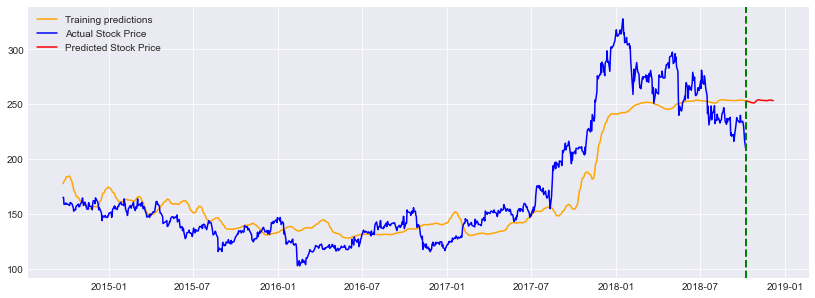

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-09-24'
plt.plot(TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:].index,TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')
plt.plot(FUTURE_PRED.index, FUTURE_PRED['Open'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(FUTURE_PRED.index), color='green', linewidth=2, linestyle='--')
plt.legend()

In [45]:
Performance =  TRAIN_PRED['Open']-df['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/df['Open'])
net_Percentage_SMA = Percentage.mean()
net_Percentage_SMA

89.64294673263183

In [46]:
Performance =  FUTURE_PRED['Open']-dm['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/dm['Open'])
net_Percentage_SMA_future = Percentage.mean()
net_Percentage_SMA_future

83.61482217414795

# LSTM with 8 features which includes SMA and Bollinger Bands Technical Indicators

In [47]:
data = pd.read_csv('stock_price_dada_inverse.csv')
data.drop('Total Trade Quantity', axis=1, inplace=True)
data.drop('Turnover (Lacs)', axis=1, inplace=True)
data

,Date,Open,High,Low,Last,Close
0,2013-10-08,157.00,157.80,155.20,155.80,155.80
1,2013-10-09,155.70,158.20,154.15,155.30,155.55
2,2013-10-10,156.00,160.80,155.85,160.30,160.15
3,2013-10-11,161.15,163.45,159.00,159.80,160.05
4,2013-10-14,160.85,161.45,157.70,159.30,159.45
...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20


In [48]:
def SimpleMovingAverage(datas, window):
    sma = datas.rolling(window = window).mean()
    return sma

data['sma_20'] = SimpleMovingAverage(data['Open'], 20)

In [49]:
def bollinger_bands(datas, sma, window):
    std = datas.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

data['UpperBand'], data['LowerBand'] = bollinger_bands(data['Close'], data['sma_20'], 20)
data.fillna(0)

,Date,Open,High,Low,Last,Close,sma_20,UpperBand,LowerBand
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,0.000,0.000000,0.000000
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,0.000,0.000000,0.000000
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,0.000,0.000000,0.000000
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,0.000,0.000000,0.000000
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,230.750,243.936612,217.563388
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,230.400,243.457891,217.342109
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,229.775,243.322561,216.227439
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,228.715,244.710891,212.719109


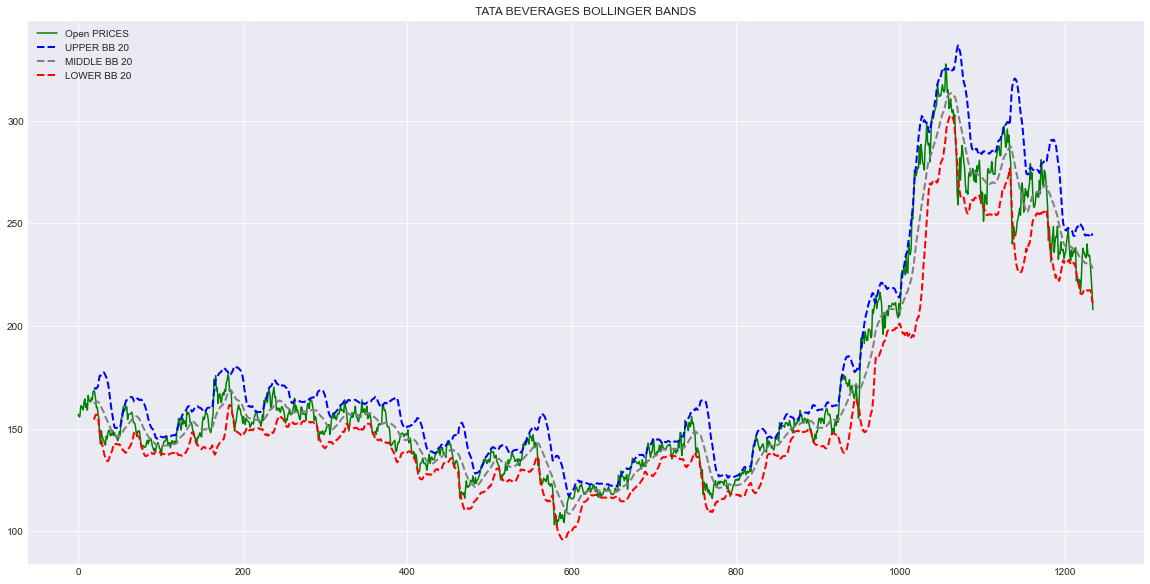

In [50]:
#Plotting Bolling Bands with the help of Upper ,Lower and Simple Moving average line which together constitute a Bollinger Band as seen in the visualized figure

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (20, 10)
data['Open'].plot(label = 'Open PRICES', color = 'green')
data['UpperBand'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 2, color = 'blue')
data['sma_20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 2, color = 'grey')
data['LowerBand'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 2, color = 'red')
plt.legend(loc = 'upper left')
plt.title('TATA BEVERAGES BOLLINGER BANDS')
plt.show()

In [51]:
columns = list(data)[1:9]
date = list(data['Date'])
date = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date]


print('Number of features selected: {}'.format(columns))

Number of features selected: ['Open', 'High', 'Low', 'Last', 'Close', 'sma_20', 'UpperBand', 'LowerBand']


In [52]:
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

data = data.astype(float)

# Using multiple features (predictors)
train_values = data.values

print('Shape of training set == {}.'.format(train_values.shape))
train_values=pd.DataFrame(train_values)
train_values.fillna(0)
train_values=train_values[train_values.index >= 19]
train_values.head(20)
train_values=train_values.values

Shape of training set == (1235, 8).


In [53]:
r = StandardScaler()
train_scaling = r.fit_transform(train_values)

scaling = StandardScaler()
scaling.fit_transform(train_values[:, 0:1])

array([[-0.0109516 ],
       [-0.02637499],
       [-0.08999651],
       ...,
       [ 1.049407  ],
       [ 0.92409189],
       [ 0.75057867]])

In [54]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(train_scaling) - n_future +1):
    X_train.append(train_scaling[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(train_scaling[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1067, 90, 7).
y_train shape == (1067, 1).


In [55]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = "adam", loss='mean_squared_error')

In [56]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 5s 542ms/step - loss: 0.2899 - val_loss: 1.9229

Epoch 00001: val_loss improved from inf to 1.92288, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 0s 112ms/step - loss: 0.2025 - val_loss: 1.7817

Epoch 00002: val_loss improved from 1.92288 to 1.78172, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 0s 112ms/step - loss: 0.1991 - val_loss: 1.8099

Epoch 00003: val_loss did not improve from 1.78172
Epoch 4/30
4/4 [==============================] - 0s 110ms/step - loss: 0.1911 - val_loss: 1.7502

Epoch 00004: val_loss improved from 1.78172 to 1.75016, saving model to weights.h5
Epoch 5/30
4/4 [==============================] - 0s 116ms/step - loss: 0.1934 - val_loss: 1.5780

Epoch 00005: val_loss improved from 1.75016 to 1.57797, saving model to weights.h5
Epoch 6/30
4/4 [==============================] - 0s 120ms/step - loss: 0.1659 - val_loss: 1.4060

Epoch 00006: val_loss impro

In [57]:
future_list = pd.date_range(date[-1], periods=n_future, freq='1d').tolist()

future_list_ = []
for this_timestamp in future_list:
    future_list_.append(this_timestamp.date())

In [58]:
train_predict = model.predict(X_train[n_past:])
future_predict = model.predict(X_train[-n_future:])

In [59]:
def timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [60]:
predicted_train = scaling.inverse_transform(train_predict)
predicted_future = scaling.inverse_transform(future_predict)

In [61]:
predicted_train.shape,predicted_future.shape

((977, 1), (60, 1))

In [62]:
FUTURE_PRED = pd.DataFrame(predicted_future, columns=['Open']).set_index(pd.Series(future_list))
TRAIN_PRED = pd.DataFrame(predicted_train, columns=['Open']).set_index(pd.Series(date[2 * n_past + n_future -1+19:]))

In [63]:
TRAIN_PRED.index = TRAIN_PRED.index.to_series().apply(timestamp)
TRAIN_PRED.tail()

,Open
2018-10-01,300.449799
2018-10-03,300.400238
2018-10-04,300.301727
2018-10-05,300.164246
2018-10-08,300.206573


In [64]:
FUTURE_PRED.index = FUTURE_PRED.index.to_series().apply(timestamp)
FUTURE_PRED.tail()

,Open
2018-12-02,300.449799
2018-12-03,300.400238
2018-12-04,300.301727
2018-12-05,300.164246
2018-12-06,300.206573


In [65]:
df = pd.read_csv ("stock_price_dada_inverse.csv")
df = df.set_index('Date')
df = df[df.index >= '2014-10-28']
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2014-10-28,156.75,157.55,156.05,156.35,156.35,1153614.0,1806.42
2014-10-29,157.00,158.25,156.60,157.40,157.30,1079352.0,1700.60
2014-10-30,157.15,158.95,156.90,157.25,157.45,4589900.0,7236.35
2014-10-31,158.90,161.20,158.05,160.15,160.10,4750346.0,7604.24
2014-11-03,161.00,164.20,160.10,163.30,163.75,2713036.0,4416.86
...,...,...,...,...,...,...,...
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [66]:
#link for next 60 day Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days
dk = pd.read_csv('Tata Global Beverages Ltd Next 60 Days__.csv')
dk = dk.set_index('Date')
dm = pd.DataFrame(dk, columns=['Open']).set_index(pd.Series(future_list))
dm.tail()

,Open
2018-12-02,223.00
2018-12-03,219.55
2018-12-04,218.50
2018-12-05,214.20
2018-12-06,212.00


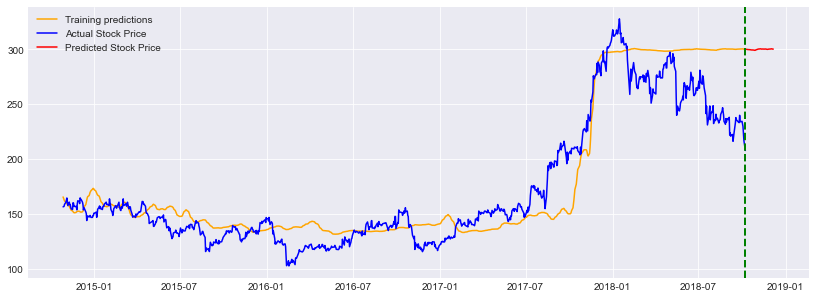

In [67]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-09-24'
plt.plot(TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:].index,TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')
plt.plot(FUTURE_PRED.index, FUTURE_PRED['Open'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(FUTURE_PRED.index), color='green', linewidth=2, linestyle='--')
plt.legend()

In [68]:
Performance =  TRAIN_PRED['Open']-df['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/df['Open'])
net_Percentage_SMA_BB = Percentage.mean()
net_Percentage_SMA_BB

89.63731576580285

In [69]:
Performance =  FUTURE_PRED['Open']-dm['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/dm['Open'])
net_Percentage_SMA_BB_future = Percentage.mean()
net_Percentage_SMA_BB_future

62.03522099243907

# LSTM with 10 features which includes SMA, Bollinger Bands and Stochastics Technical Indicators

In [70]:
data = pd.read_csv('stock_price_dada_inverse.csv')
data.drop('Total Trade Quantity', axis=1, inplace=True)
data.drop('Turnover (Lacs)', axis=1, inplace=True)
data

,Date,Open,High,Low,Last,Close
0,2013-10-08,157.00,157.80,155.20,155.80,155.80
1,2013-10-09,155.70,158.20,154.15,155.30,155.55
2,2013-10-10,156.00,160.80,155.85,160.30,160.15
3,2013-10-11,161.15,163.45,159.00,159.80,160.05
4,2013-10-14,160.85,161.45,157.70,159.30,159.45
...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20


In [71]:
def SimpleMovingAverage(datas, window):
    sma = datas.rolling(window = window).mean()
    return sma

data['sma_20'] = SimpleMovingAverage(data['Open'], 20)

In [72]:
def bollinger_bands(datas, sma, window):
    std = datas.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

data['UpperBand'], data['LowerBand'] = bollinger_bands(data['Close'], data['sma_20'], 20)

In [73]:
def stochastics( dataframe, low, high, close, k, d ):

    lowest_minimum  = dataframe[low].rolling( window = k ).min()
    highest_maximum = dataframe[high].rolling( window = k ).max()

    dataframe['%k'] = 100 * (dataframe[close] - lowest_minimum)/(highest_maximum - lowest_minimum)
    dataframe['%d'] = dataframe['%k'].rolling(window = d).mean()

    return dataframe

stochs = stochastics( data, 'Low', 'High', 'Open', 14, 3 )
data.fillna(0)

,Date,Open,High,Low,Last,Close,sma_20,UpperBand,LowerBand,%k,%d
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,0.000,0.000000,0.000000,0.000000,0.000000
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,0.000,0.000000,0.000000,0.000000,0.000000
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,0.000,0.000000,0.000000,0.000000,0.000000
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,0.000,0.000000,0.000000,0.000000,0.000000
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,230.750,243.936612,217.563388,80.073126,79.463742
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,230.400,243.457891,217.342109,63.436929,73.918342
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,229.775,243.322561,216.227439,39.670932,61.060329
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,228.715,244.710891,212.719109,32.551320,45.219727


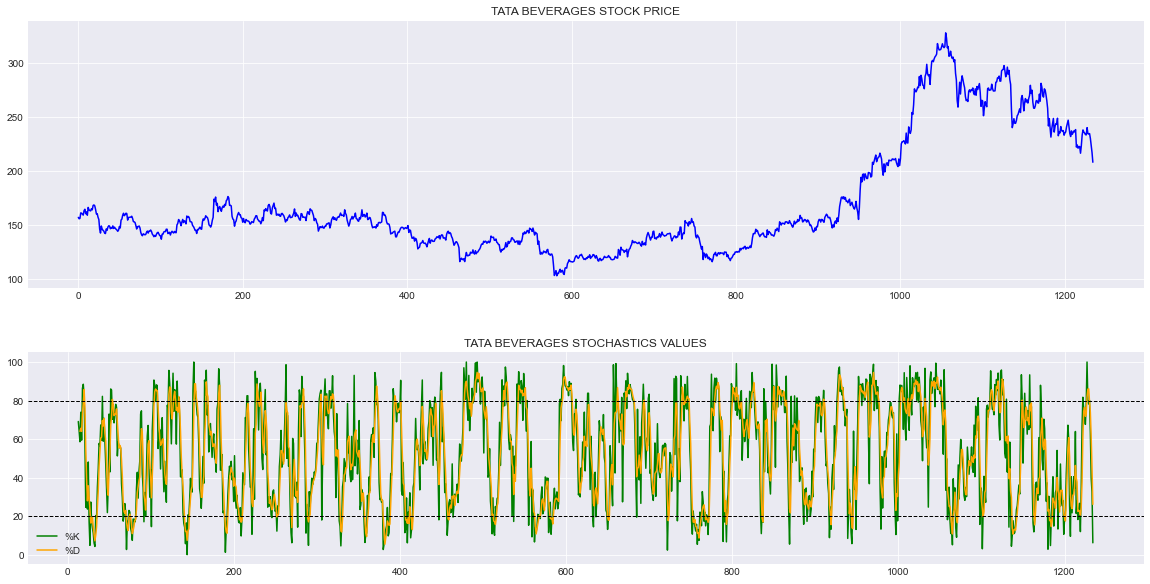

In [74]:
#Plotting Stochastic Oscillator with the help of %K and %D values and plotting a lower and upper reference lines of 80 and 20 mark

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (20, 10)
def Stochastics_Plotting(name, price, k, d):
    axis1 = plt.subplot2grid((10, 1), (0,0), rowspan = 5, colspan = 1)
    axis2 = plt.subplot2grid((10, 1), (6,0), rowspan = 4, colspan = 1)
    axis1.plot(data['Open'], color = 'blue', label = 'STOCK CHART')
    axis1.set_title(f'{name} STOCK PRICE')
    axis2.plot(k, color = 'green', linewidth = 1.5, label = '%K')
    axis2.plot(d, color = 'orange', linewidth = 1.5, label = '%D')
    axis2.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
    axis2.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
    axis2.set_title(f'{name} STOCHASTICS VALUES')
    axis2.legend()
    plt.show()
    
Stochastics_Plotting('TATA BEVERAGES', data['Open'], data['%k'], data['%d'])

In [75]:
columns = list(data)[1:11]
date = list(data['Date'])
date = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date]


print('Number of features selected: {}'.format(columns))

Number of features selected: ['Open', 'High', 'Low', 'Last', 'Close', 'sma_20', 'UpperBand', 'LowerBand', '%k', '%d']


In [76]:
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

data = data.astype(float)

# Using multiple features (predictors)
train_values = data.values

print('Shape of training set == {}.'.format(train_values.shape))
train_values=pd.DataFrame(train_values)
train_values.fillna(0)
train_values=train_values[train_values.index >= 19]
train_values.head(20)
train_values=train_values.values

Shape of training set == (1235, 10).


In [77]:
r = StandardScaler()
train_scaling = r.fit_transform(train_values)

scaling = StandardScaler()
scaling.fit_transform(train_values[:, 0:1])

array([[-0.0109516 ],
       [-0.02637499],
       [-0.08999651],
       ...,
       [ 1.049407  ],
       [ 0.92409189],
       [ 0.75057867]])

In [78]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(train_scaling) - n_future +1):
    X_train.append(train_scaling[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(train_scaling[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1067, 90, 9).
y_train shape == (1067, 1).


In [79]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = "adam", loss='mean_squared_error')

In [80]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 5s 511ms/step - loss: 0.4726 - val_loss: 3.0974

Epoch 00001: val_loss improved from inf to 3.09737, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 1s 132ms/step - loss: 0.2282 - val_loss: 2.1551

Epoch 00002: val_loss improved from 3.09737 to 2.15511, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 1s 127ms/step - loss: 0.2112 - val_loss: 1.9237

Epoch 00003: val_loss improved from 2.15511 to 1.92375, saving model to weights.h5
Epoch 4/30
4/4 [==============================] - 1s 151ms/step - loss: 0.1699 - val_loss: 1.8439

Epoch 00004: val_loss improved from 1.92375 to 1.84393, saving model to weights.h5
Epoch 5/30
4/4 [==============================] - 1s 126ms/step - loss: 0.1856 - val_loss: 1.7024

Epoch 00005: val_loss improved from 1.84393 to 1.70244, saving model to weights.h5
Epoch 6/30
4/4 [==============================] - 1s 145ms/step - loss: 0.1826 - val_loss: 1.5

In [81]:
future_list = pd.date_range(date[-1], periods=n_future, freq='1d').tolist()

future_list_ = []
for this_timestamp in future_list:
    future_list_.append(this_timestamp.date())

In [82]:
train_predict = model.predict(X_train[n_past:])
future_predict = model.predict(X_train[-n_future:])

In [83]:
def timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [84]:
predicted_train = scaling.inverse_transform(train_predict)
predicted_future = scaling.inverse_transform(future_predict)

In [85]:
predicted_train.shape,predicted_future.shape

((977, 1), (60, 1))

In [86]:
FUTURE_PRED = pd.DataFrame(predicted_future, columns=['Open']).set_index(pd.Series(future_list))
TRAIN_PRED = pd.DataFrame(predicted_train, columns=['Open']).set_index(pd.Series(date[2 * n_past + n_future -1+19:]))

In [87]:
TRAIN_PRED.index = TRAIN_PRED.index.to_series().apply(timestamp)
TRAIN_PRED.tail()

,Open
2018-10-01,278.089050
2018-10-03,277.591614
2018-10-04,278.180756
2018-10-05,279.082642
2018-10-08,279.414764


In [88]:
FUTURE_PRED.index = FUTURE_PRED.index.to_series().apply(timestamp)
FUTURE_PRED.tail()

,Open
2018-12-02,278.089050
2018-12-03,277.591614
2018-12-04,278.180756
2018-12-05,279.082642
2018-12-06,279.414764


In [89]:
df = pd.read_csv ("stock_price_dada_inverse.csv")
df = df.set_index('Date')
df = df[df.index >= '2014-10-28']
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2014-10-28,156.75,157.55,156.05,156.35,156.35,1153614.0,1806.42
2014-10-29,157.00,158.25,156.60,157.40,157.30,1079352.0,1700.60
2014-10-30,157.15,158.95,156.90,157.25,157.45,4589900.0,7236.35
2014-10-31,158.90,161.20,158.05,160.15,160.10,4750346.0,7604.24
2014-11-03,161.00,164.20,160.10,163.30,163.75,2713036.0,4416.86
...,...,...,...,...,...,...,...
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [90]:
#link for next 60 day Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days
dk = pd.read_csv('Tata Global Beverages Ltd Next 60 Days__.csv')
dk = dk.set_index('Date')
dm = pd.DataFrame(dk, columns=['Open']).set_index(pd.Series(future_list))
dm.tail()

,Open
2018-12-02,223.00
2018-12-03,219.55
2018-12-04,218.50
2018-12-05,214.20
2018-12-06,212.00


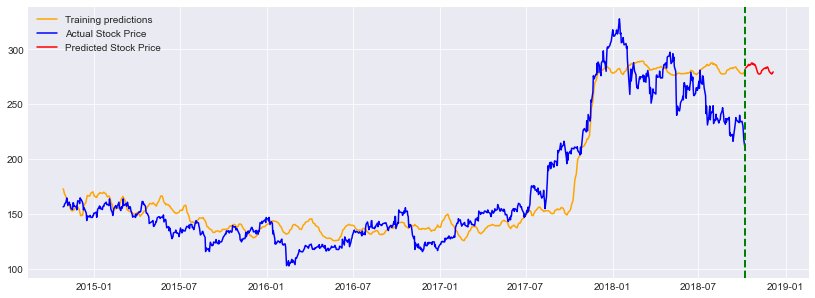

In [91]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-09-24'
plt.plot(TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:].index,TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')
plt.plot(FUTURE_PRED.index, FUTURE_PRED['Open'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(FUTURE_PRED.index), color='green', linewidth=2, linestyle='--')
plt.legend()

In [92]:
Performance =  TRAIN_PRED['Open']-df['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/df['Open'])
net_Percentage_SMA_BB_SO = Percentage.mean()
net_Percentage_SMA_BB_SO

90.86105636716563

In [93]:
Performance =  FUTURE_PRED['Open']-dm['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/dm['Open'])
net_Percentage_SMA_BB_SO_future = Percentage.mean()
net_Percentage_SMA_BB_SO_future

70.13637796801609

# LSTM with 13 features which includes SMA, Bollinger Bands and Stochastics Technical Indicators and MACD

In [94]:
data = pd.read_csv('stock_price_dada_inverse.csv')
data.drop('Total Trade Quantity', axis=1, inplace=True)
data.drop('Turnover (Lacs)', axis=1, inplace=True)
data

,Date,Open,High,Low,Last,Close
0,2013-10-08,157.00,157.80,155.20,155.80,155.80
1,2013-10-09,155.70,158.20,154.15,155.30,155.55
2,2013-10-10,156.00,160.80,155.85,160.30,160.15
3,2013-10-11,161.15,163.45,159.00,159.80,160.05
4,2013-10-14,160.85,161.45,157.70,159.30,159.45
...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20


In [95]:
def SimpleMovingAverage(datas, window):
    sma = datas.rolling(window = window).mean()
    return sma

data['sma_20'] = SimpleMovingAverage(data['Open'], 20)

In [96]:
def bollinger_bands(datas, sma, window):
    std = datas.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

data['UpperBand'], data['LowerBand'] = bollinger_bands(data['Close'], data['sma_20'], 20)

In [97]:
def stochastics( dataframe, low, high, close, k, d ):

    lowest_minimum  = dataframe[low].rolling( window = k ).min()
    highest_maximum = dataframe[high].rolling( window = k ).max()

    dataframe['%k'] = 100 * (dataframe[close] - lowest_minimum)/(highest_maximum - lowest_minimum)
    dataframe['%d'] = dataframe['%k'].rolling(window = d).mean()

    return dataframe

stochs = stochastics( data, 'Low', 'High', 'Open', 14, 3 )

In [98]:
def get_macd(dataframe, price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    dataframe['macd'] = pd.DataFrame(exp1 - exp2)
    dataframe['Signal'] =(dataframe['macd'].ewm(span = smooth, adjust = False).mean())
    dataframe['Histogram'] = (dataframe['macd'] - dataframe['Signal'])    
    return dataframe

data = get_macd(data,data['Close'], 26, 12, 9)
data.fillna(0)

,Date,Open,High,Low,Last,Close,sma_20,UpperBand,LowerBand,%k,%d,macd,Signal,Histogram
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,0.000,0.000000,0.000000,0.000000,0.000000,-0.019943,-0.003989,-0.015954
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,0.000,0.000000,0.000000,0.000000,0.000000,0.331611,0.063131,0.268480
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,0.000,0.000000,0.000000,0.000000,0.000000,0.595289,0.169563,0.425726
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,0.000,0.000000,0.000000,0.000000,0.000000,0.747227,0.285096,0.462131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,230.750,243.936612,217.563388,80.073126,79.463742,-0.625160,-1.492038,0.866878
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,230.400,243.457891,217.342109,63.436929,73.918342,-0.967272,-1.387084,0.419813
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,229.775,243.322561,216.227439,39.670932,61.060329,-1.974143,-1.504496,-0.469647
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,228.715,244.710891,212.719109,32.551320,45.219727,-3.458453,-1.895287,-1.563166


In [99]:
columns = list(data)[1:14]
date = list(data['Date'])
date = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date]


print('Number of features selected: {}'.format(columns))

Number of features selected: ['Open', 'High', 'Low', 'Last', 'Close', 'sma_20', 'UpperBand', 'LowerBand', '%k', '%d', 'macd', 'Signal', 'Histogram']


In [100]:
data = data[columns].astype(str)
for i in columns:
    for j in range(0, len(data)):
        data[i][j] = data[i][j].replace(',', '')

data = data.astype(float)

# Using multiple features (predictors)
train_values = data.values

print('Shape of training set == {}.'.format(train_values.shape))
train_values=pd.DataFrame(train_values)
train_values.fillna(0)
train_values=train_values[train_values.index >= 19]
train_values.head(20)
train_values=train_values.values

Shape of training set == (1235, 13).


In [101]:
r = StandardScaler()
train_scaling = r.fit_transform(train_values)

scaling = StandardScaler()
scaling.fit_transform(train_values[:, 0:1])

array([[-0.0109516 ],
       [-0.02637499],
       [-0.08999651],
       ...,
       [ 1.049407  ],
       [ 0.92409189],
       [ 0.75057867]])

In [102]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(train_scaling) - n_future +1):
    X_train.append(train_scaling[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(train_scaling[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1067, 90, 12).
y_train shape == (1067, 1).


In [103]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = "adam", loss='mean_squared_error')

In [104]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - 5s 546ms/step - loss: 0.7972 - val_loss: 4.3994

Epoch 00001: val_loss improved from inf to 4.39944, saving model to weights.h5
Epoch 2/30
4/4 [==============================] - 1s 178ms/step - loss: 0.3196 - val_loss: 3.9213

Epoch 00002: val_loss improved from 4.39944 to 3.92127, saving model to weights.h5
Epoch 3/30
4/4 [==============================] - 1s 168ms/step - loss: 0.2192 - val_loss: 3.5772

Epoch 00003: val_loss improved from 3.92127 to 3.57716, saving model to weights.h5
Epoch 4/30
4/4 [==============================] - 1s 182ms/step - loss: 0.2182 - val_loss: 3.3776

Epoch 00004: val_loss improved from 3.57716 to 3.37757, saving model to weights.h5
Epoch 5/30
4/4 [==============================] - 1s 142ms/step - loss: 0.1937 - val_loss: 3.2544

Epoch 00005: val_loss improved from 3.37757 to 3.25440, saving model to weights.h5
Epoch 6/30
4/4 [==============================] - 1s 136ms/step - loss: 0.1875 - val_loss: 3.1

In [105]:
future_list = pd.date_range(date[-1], periods=n_future, freq='1d').tolist()

future_list_ = []
for this_timestamp in future_list:
    future_list_.append(this_timestamp.date())

In [106]:
train_predict = model.predict(X_train[n_past:])
future_predict = model.predict(X_train[-n_future:])

In [107]:
def timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [108]:
predicted_train = scaling.inverse_transform(train_predict)
predicted_future = scaling.inverse_transform(future_predict)

In [109]:
predicted_train.shape,predicted_future.shape

((977, 1), (60, 1))

In [110]:
FUTURE_PRED = pd.DataFrame(predicted_future, columns=['Open']).set_index(pd.Series(future_list))
TRAIN_PRED = pd.DataFrame(predicted_train, columns=['Open']).set_index(pd.Series(date[2 * n_past + n_future -1+19:]))

In [111]:
TRAIN_PRED.index = TRAIN_PRED.index.to_series().apply(timestamp)
TRAIN_PRED.tail()

,Open
2018-10-01,184.845490
2018-10-03,186.765778
2018-10-04,188.740036
2018-10-05,190.300629
2018-10-08,191.581177


In [112]:
FUTURE_PRED.index = FUTURE_PRED.index.to_series().apply(timestamp)
FUTURE_PRED.tail()

,Open
2018-12-02,184.845490
2018-12-03,186.765778
2018-12-04,188.740036
2018-12-05,190.300629
2018-12-06,191.581177


In [113]:
df = pd.read_csv ("stock_price_dada_inverse.csv")
df = df.set_index('Date')
df = df[df.index >= '2014-10-28']
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2014-10-28,156.75,157.55,156.05,156.35,156.35,1153614.0,1806.42
2014-10-29,157.00,158.25,156.60,157.40,157.30,1079352.0,1700.60
2014-10-30,157.15,158.95,156.90,157.25,157.45,4589900.0,7236.35
2014-10-31,158.90,161.20,158.05,160.15,160.10,4750346.0,7604.24
2014-11-03,161.00,164.20,160.10,163.30,163.75,2713036.0,4416.86
...,...,...,...,...,...,...,...
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79


In [114]:
#link for next 60 day Stock data : https://www.kaggle.com/usuanhthja/tata-global-beverages-ltd-next-60-days
dk = pd.read_csv('Tata Global Beverages Ltd Next 60 Days__.csv')
dk = dk.set_index('Date')
dm = pd.DataFrame(dk, columns=['Open']).set_index(pd.Series(future_list))
dm.tail()

,Open
2018-12-02,223.00
2018-12-03,219.55
2018-12-04,218.50
2018-12-05,214.20
2018-12-06,212.00


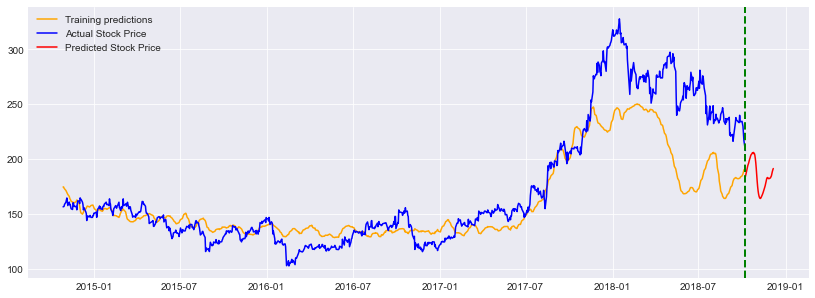

In [115]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2014-10-28'
plt.plot(TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:].index,TRAIN_PRED.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')
plt.plot(FUTURE_PRED.index, FUTURE_PRED['Open'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(FUTURE_PRED.index), color='green', linewidth=2, linestyle='--')
plt.legend()

In [116]:
Performance =  TRAIN_PRED['Open']-df['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/df['Open'])
net_Percentage_SMA_BB_SO_MACD = Percentage.mean()
net_Percentage_SMA_BB_SO_MACD

89.90596237183195

In [117]:
Performance =  FUTURE_PRED['Open']-dm['Open']
Performance = pd.DataFrame(Performance)
Performance['Open'] = Performance['Open'].abs()
Percentage = 100 - (Performance['Open']*100/dm['Open'])
net_Percentage_SMA_BB_SO_MACD_future = Percentage.mean()
net_Percentage_SMA_BB_SO_MACD_future

85.30034645408186

# PERFORMANCE

In [118]:
data = {'Trend Technique':['LSTM with ORIGINAL DATASET', 'LSTM with ORIGINAL DATASET+SMA', 'LSTM with ORIGINAL DATASET+SMA+BB', 'LSTM with ORIGINAL DATASET+SMA+BB+SO', 'LSTM with ORIGINAL DATASET+SMA+BB+SO+MACD'],
        'NET Performance':[net_Percentage_Original, net_Percentage_SMA, net_Percentage_SMA_BB, net_Percentage_SMA_BB_SO, net_Percentage_SMA_BB_SO_MACD],
       'NET future Performance':[net_Percentage_Original_future, net_Percentage_SMA_future, net_Percentage_SMA_BB_future, net_Percentage_SMA_BB_SO_future, net_Percentage_SMA_BB_SO_MACD_future]}
data = pd.DataFrame(data)
data

,Trend Technique,NET Performance,NET future Performance
0,LSTM with ORIGINAL DATASET,89.201563,65.046366
1,LSTM with ORIGINAL DATASET+SMA,89.642947,83.614822
2,LSTM with ORIGINAL DATASET+SMA+BB,89.637316,62.035221
3,LSTM with ORIGINAL DATASET+SMA+BB+SO,90.861056,70.136378
4,LSTM with ORIGINAL DATASET+SMA+BB+SO+MACD,89.905962,85.300346


In [119]:
data.to_csv("Result.csv")

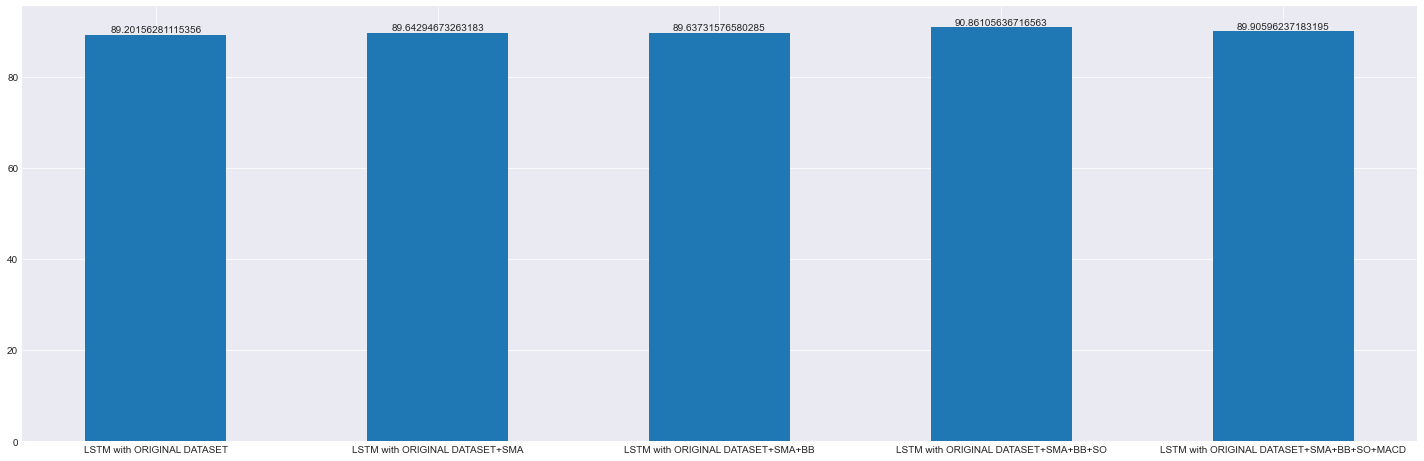

In [120]:
lis_name = []
lis_val = []
for i in range(len(data)):
  lis_name.append(data["Trend Technique"].iloc[i])
  lis_val.append(data["NET Performance"].iloc[i])
fig, ax = plt.subplots(figsize=(25,8))
bars = ax.bar(lis_name, lis_val, width=0.5)
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')

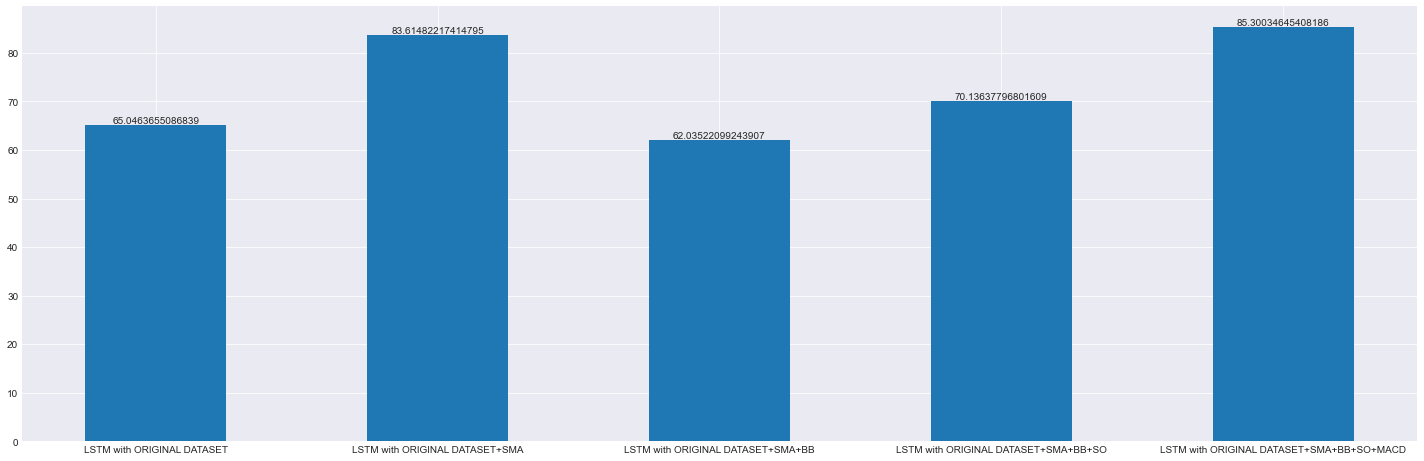

In [121]:
lis_name = []
lis_val = []
for i in range(len(data)):
  lis_name.append(data["Trend Technique"].iloc[i])
  lis_val.append(data["NET future Performance"].iloc[i])
fig, ax = plt.subplots(figsize=(25,8))
bars = ax.bar(lis_name, lis_val, width=0.5)
for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{height}', ha='center',
  va='bottom')